# <P style=color:orange>CICLO 1: 29/03 - 04/04</P>

# CONTEXTO DO PROBLEMA

# O PROBLEMA

# ENTENDIMENTO DO PROBLEMA

# 0.0 IMPORTS

In [1]:
import pandas as pd
import inflection
import matplotlib.pyplot as plt
import seaborn as sns

## 0.1 Funções Auxiliares

## 0.2 Carregamento de Dados

In [18]:
# loading data
df = pd.read_csv('../data/Churn.csv')

# show data
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 1.0 DESCRIÇÃO DE DADOS

## 1.1 Dimensão de Dados

In [19]:
df1 = df.copy()

print('Nº Rows:', df1.shape[0])
print('Nº Cols:', df1.shape[1])

Nº Rows: 10000
Nº Cols: 14


## 1.2 Renomeação de Colunas

In [20]:
# Columns to snakecase
snakecase = lambda x: inflection.underscore(x)

# New columns with snakecase
new_columns = (map(snakecase, df1.columns))
df1.columns = new_columns

# show new columns
df1.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

## 1.3 Tipo de Dados

In [21]:
# show data type
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.4 Verificação de Dados Faltantes

In [22]:
# show data NaN
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5 Estatistica Descritiva

### 1.5.1 Variavel Numérica

In [23]:
# show data description 
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
row_number,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
customer_id,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
credit_score,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
num_of_products,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
has_cr_card,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
is_active_member,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
estimated_salary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


**Insight:**

<ins>Distribuição</ins>: 

<ins>Negócio</ins>:

### 1.5.2 Variavel Categórica

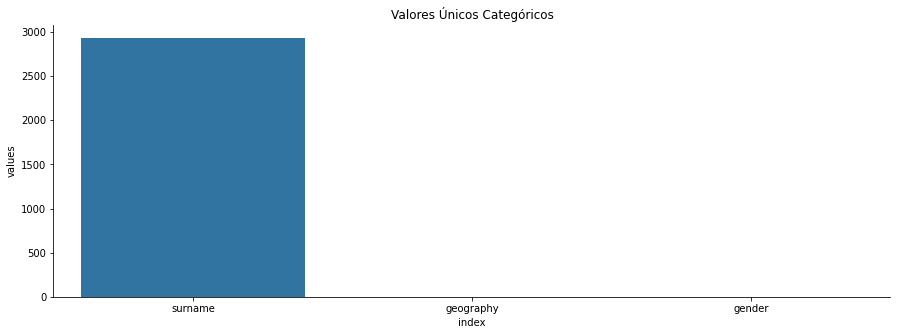

In [24]:
categorical = df1.select_dtypes(include=['object']) # filter categorical
qty_values = categorical.apply(lambda x: len(x.unique())).reset_index().rename(columns={0: 'values'}) # count unique values

# Create figure
plt.figure(figsize=(15, 5))
sns.barplot(x='index', y='values', data=qty_values)
plt.title('Valores Únicos Categóricos')
sns.despine(right=True);

**Insight:**

No geral, as variaveis categóricas não posuem um grande range de possíveis valores, com exceção de Surname que contém cerca de 3 mil.

# 2.0 FEATURE ENGINEERING

## 2.1 Mapa Mental de Hipóteses

<p align="center">
  <img src="../img/mind_map.png" width="1000" title="mind_map">
</p>

## 2.2 Hipóteses 

**1.** Clientes com menor saldo, dão mais Churn.

**2.** Clientes com menor Credit Score, dão mais Churn.

**3.** Clientes que não são ativos, dão mais Churn.

**4.** Clientes do sexo Masculino, dão mais Churn.

**5.** Clientes acima de 40 anos, dão mais Churn.

## 2.3 Feature Engineering 

In [64]:
df4['category_age'] = df4['age'].apply(lambda x: '>= 40' if x > 40 else '< 40')

# 3.0 FILTRAGEM DE DADOS

# 4.0 EDA

## 4.1 Análise Univariada

### 4.1.1 Variavel Target

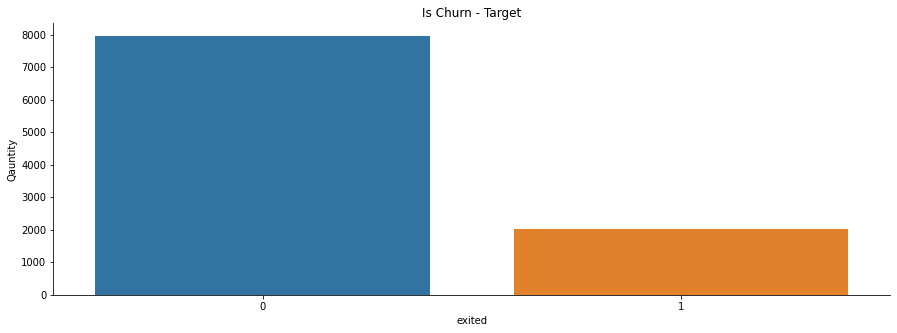

In [27]:
df4 = df1.copy()

plt.figure(figsize=(15, 5))
sns.countplot(x='exited', data=df4)
plt.title('Is Churn - Target')
plt.ylabel('Qauntity')
sns.despine(right=True)

### 4.1.2 Variavel Numérica

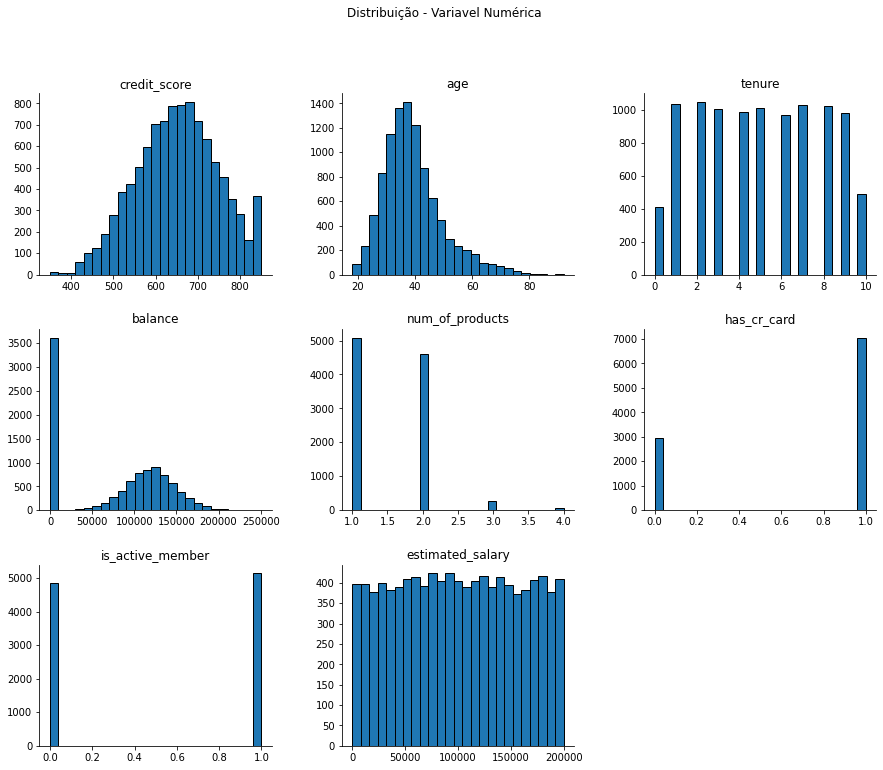

In [42]:
num = df4.select_dtypes(include=['int64', 'float64']).drop(columns=['customer_id', 'row_number', 'exited'])

num.hist(figsize=(15, 12), grid=False, bins=25, ec='k')
plt.suptitle('Distribuição - Variavel Numérica')
sns.despine(right=True);

### 4.1.1 Variavel Categórica

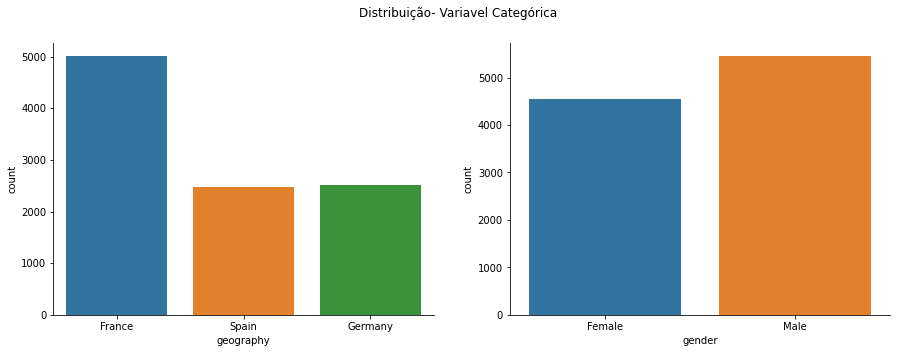

In [53]:
cat = df4.select_dtypes(include=['object']).drop(columns='surname')

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='geography', data=cat)
plt.suptitle('Distribuição- Variavel Categórica')
sns.despine(right=True)

plt.subplot(1, 2, 2)
sns.countplot(x='gender', data=cat)
sns.despine(right=True);

## 4.2 Análise Bivariada

### **1.** Clientes com menor saldo, dão mais Churn.

**FALSA** Clientes com <ins>maior saldo</ins>, dão mais Churn.

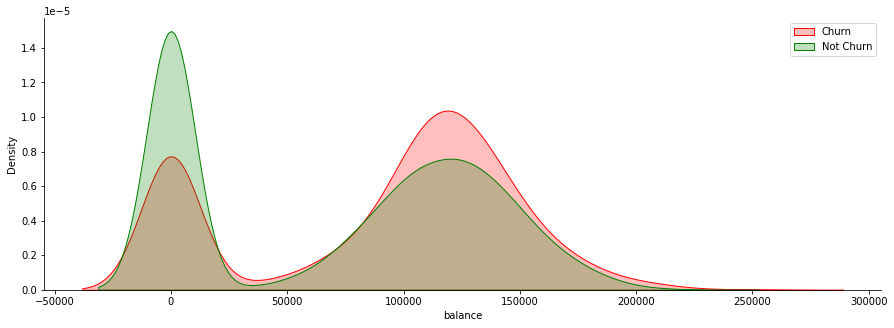

In [81]:
plt.figure(figsize=(15, 5))
sns.kdeplot(x=df4[df4['exited'] == 1]['balance'], label='Churn', shade=True, color='red')
sns.kdeplot(x=df4[df4['exited'] == 0]['balance'], label='Not Churn', shade=True, color='green')
sns.despine(right=True)
plt.legend();

### **2.** Clientes com menor Credit Score, dão mais Churn.

**VERDADEIRA** Clientes com menor Credit Score, dão mais Churn.

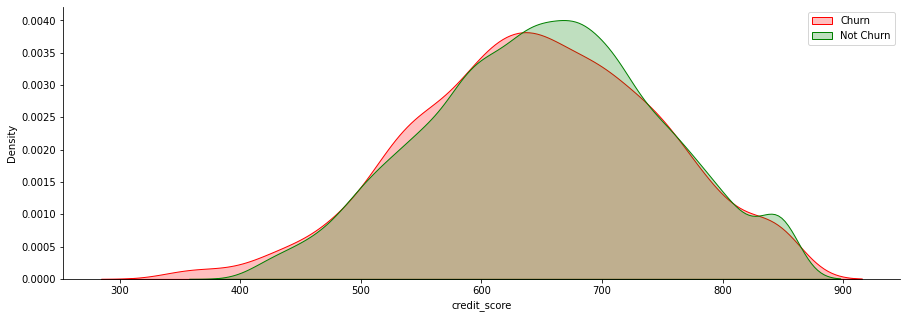

In [82]:
plt.figure(figsize=(15, 5))
sns.kdeplot(x=df4[df4['exited'] == 1]['credit_score'], label='Churn', shade=True, color='red')
sns.kdeplot(x=df4[df4['exited'] == 0]['credit_score'], label='Not Churn', shade=True, color='green')
sns.despine(right=True)
plt.legend();

### **3.** Clientes que não são ativos, dão mais Churn.


**VERDADEIRA** Clientes que não são ativos, dão mais Churn.

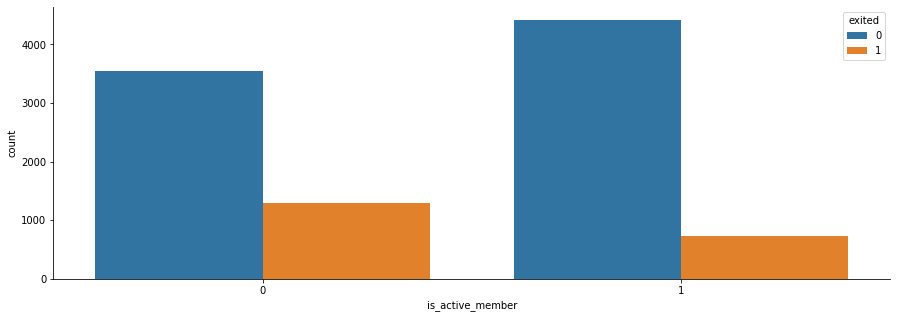

In [71]:
plt.figure(figsize=(15, 5))
sns.countplot(x='is_active_member', data=df4, hue='exited')
sns.despine(right=True);

### **4.** Clientes do sexo Masculino, dão mais Churn.

**FALSA** Clientes do sexo <ins>Feminino</ins>, dão mais Churn.

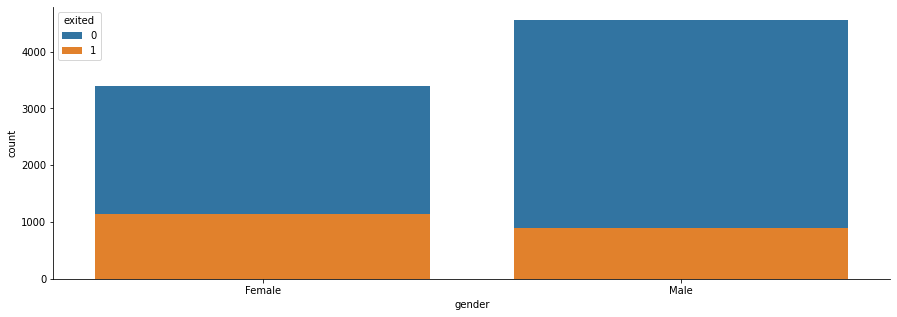

In [60]:
plt.figure(figsize=(15, 5))
sns.countplot(x='gender', data=df4, hue='exited', dodge=False)
sns.despine(right=True)

### **5.** Clientes acima de 40 anos, dão mais Churn.

**VERDADEIRA** Clientes acima de 40 anos, dão mais Churn.

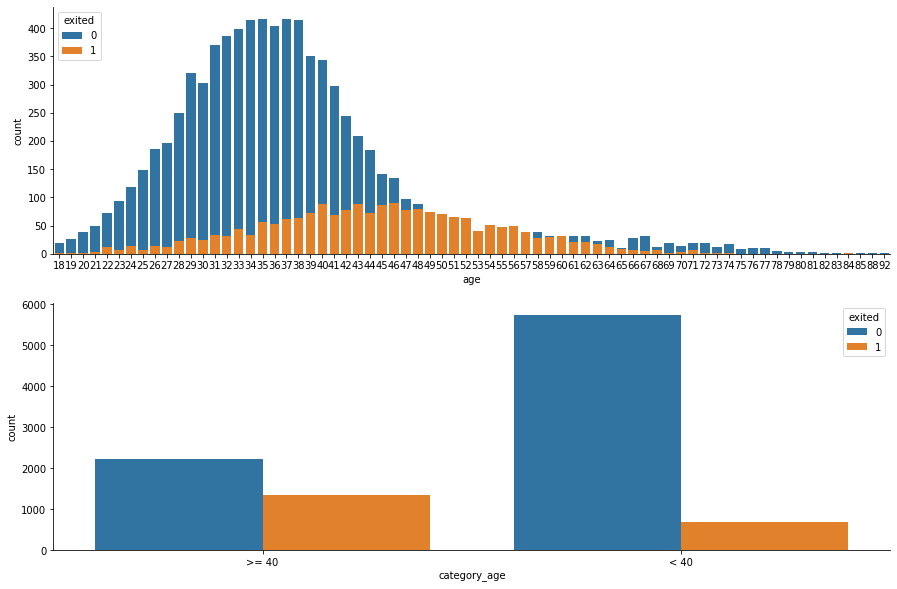

In [67]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
sns.countplot(x='age', data=df4, hue='exited', dodge=False)
sns.despine(right=True)

plt.subplot(2, 1, 2)
sns.countplot(x='category_age', data=df4, hue='exited')
sns.despine(right=True);

## 4.3 Análise Multivariada

### 4.3.1 Variavel Numérica

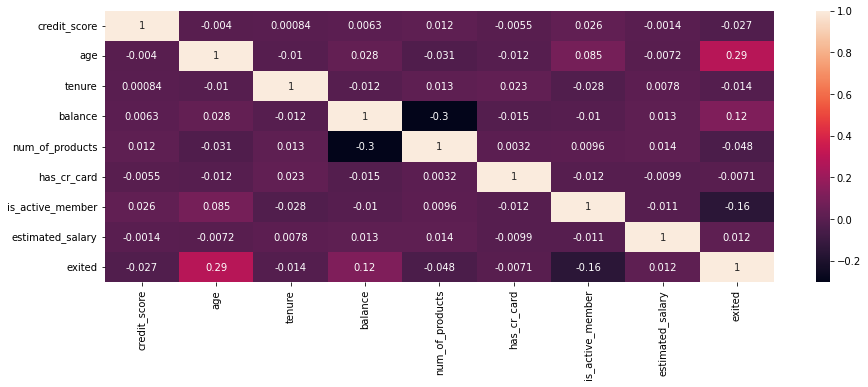

In [86]:
num = df4.select_dtypes(include=['int64', 'float64']).drop(columns=['row_number', 'customer_id'])

plt.figure(figsize=(15, 5))
sns.heatmap(num.corr(method='pearson'), annot=True);

### 4.3.2 Variavel Categórica

# 5.0 PREPARAÇÃO DE DADOS

# 6.0 SELEÇÃO DE FEATURE

# 7.0 MACHINE LEARNING

# 8.0 AJUSTE DE HIPERPARAMETROS

# 9.0 TRADUÇÃO E INTERPRETAÇÃO

# 10.0 DEPLOY